In [1]:
import numpy as np
import pandas as pd
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "/home/welton/data"
PROBS_DIR = f"{DATA_DIR}/normal_probas/split_10"
LABELS_DIR = f"{DATA_DIR}/datasets/labels/split_10"
UPPER_DIR = f"{DATA_DIR}/oracle/upper_bound/normal_probas"
STACKING_DIR = f"{DATA_DIR}/stacking/stacking_output"
CLFS = ["bert", "xlnet", "ktmk", "ktr", "lstmk", "lstr", "ltr"]
N_FOLDS = 10

In [3]:
clfs_stack = '/'.join(sorted([f"{clf}_normal_probas" for clf in CLFS ]))
clfs_stack

'bert_normal_probas/ktmk_normal_probas/ktr_normal_probas/lstmk_normal_probas/lstr_normal_probas/ltr_normal_probas/xlnet_normal_probas'

In [4]:
def load_probs(probs_source: str,
               dataset: str,
               clfs: list,
               fold: int):

    probas = {}
    for clf in clfs:
        probas[clf] = {}
        probas_dir = f"{probs_source}/{dataset}/10_folds/{clf}/{fold}/"
        train_load = np.load(f"{probas_dir}/train.npz")
        test_load = np.load(f"{probas_dir}/test.npz")
        probas[clf]["X_train"] = train_load["X_train"]
        probas[clf]["X_test"] = test_load["X_test"]
    return probas

def load_y(labels_dir: int, dataset: str, fold: int):

    ldir = f"{labels_dir}/{dataset}/{fold}"
    return np.load(f"{ldir}/train.npy"), np.load(f"{ldir}/test.npy")

def load_upper(data_source: str, dataset: str, clfs: str, fold: int):

    upper = {}
    for clf in clfs:
        upper[clf] = {}
        upper_dir = f"{data_source}/{dataset}/10_folds/{clf}/{fold}/"
        upper[clf]["y_train"] = np.load(f"{upper_dir}/train.npz")['y']
        upper[clf]["y_test"] = np.load(f"{upper_dir}/test.npz")['y']
    return upper

def get_zero_array(probas):
    return np.zeros(probas["bert"]["X_test"][0].shape[0])

def get_truth_table(rows: int, cols: int):

    truth_table = np.array([[bool(i & (1 << j)) for j in range(cols)] for i in range(rows)], dtype=bool)
    truth_table = np.where(truth_table == 1, 1, 0)
    return truth_table

def expand_docs(probas: dict, 
                clfs_idx: dict, 
                truth_table: np.ndarray):

    expanded_docs = {}
    # Para cada documento.
    for doc_idx in np.arange(probas["bert"]["X_test"].shape[0]):
        X_docs = []
        for row in truth_table:
            doc_probas = []
            for clf in clfs_idx:
                idx_clf = clfs_idx[clf]
                if row[idx_clf] == 0:
                    doc_probas.append(get_zero_array(probas))
                else:
                    doc_probas.append(probas[clf]["X_test"][doc_idx])
            X_docs.append(np.hstack(doc_probas))
        expanded_docs[doc_idx] = np.vstack(X_docs)
    return expanded_docs

In [5]:
clfs_idx = {clf:idx for idx, clf in enumerate(CLFS)}
clfs_idx

{'bert': 0, 'xlnet': 1, 'ktmk': 2, 'ktr': 3, 'lstmk': 4, 'lstr': 5, 'ltr': 6}

In [6]:
N = 2 ** len(CLFS)
truth_table = get_truth_table(N, len(CLFS))

In [7]:
truth_table

array([[0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0],
       [1, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1, 0, 0],
       [0, 1, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 0],
       [1, 1, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0, 0],
       [1, 0, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [1,

In [8]:
meta_layer = "10_folds/logistic_regression/normal_probas"
dataset = "acm"

In [9]:
combs_hits = {}
for fold in np.arange(10):
    
    combs_hits[fold] = []
    # Loading fold probas and labels.
    probas = load_probs(PROBS_DIR, "acm", CLFS, fold)
    y_train, y_test = load_y(LABELS_DIR, "acm", fold)
    # Loading trained meta-layer.
    meta_clf = load(f"{STACKING_DIR}/{dataset}/{meta_layer}/{clfs_stack}/fold_{fold}/model.joblib")
    # Expanding probabilities and labels.
    expanded_X = expand_docs(probas, clfs_idx, truth_table)
    expanded_y = [ N * [y] for y in y_test ]
    # For each document.
    for doc_idx in sorted(list(expanded_X.keys())):
        y_pred = meta_clf.predict(expanded_X[doc_idx])
        combs_hits[fold].append(np.sum(y_pred == expanded_y[doc_idx]))
    


/home/welton/project/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def get_cdf(values: list):

    counts = pd.Series(sorted(values)).value_counts()
    keys = sorted(list(counts.keys()))
    total = len(values)
    acc = 0
    cdf = []
    for key in keys:
        acc += counts[key] / total
        cdf.append(acc)
    
    cdf = np.array(cdf).tolist()
    return keys, cdf


def plot(values: list, title: str):

    counts = pd.Series(values).value_counts()
    keys = sorted(list(counts.keys()))
    y = [ counts[key] for key in keys ]
    plt.plot(keys, y)
    plt.xlabel("Num of right Combinations.")
    plt.ylabel("Num. of Docs.")
    plt.title(title)

def plot_cdf(values: list, title: str):

    keys, cdf = get_cdf(values)
    plt.plot(keys, cdf)
    plt.xlabel("Num. of Right Combinations.")
    plt.ylabel("(%) of Docs.")
    plt.title(title)
    plt.grid()

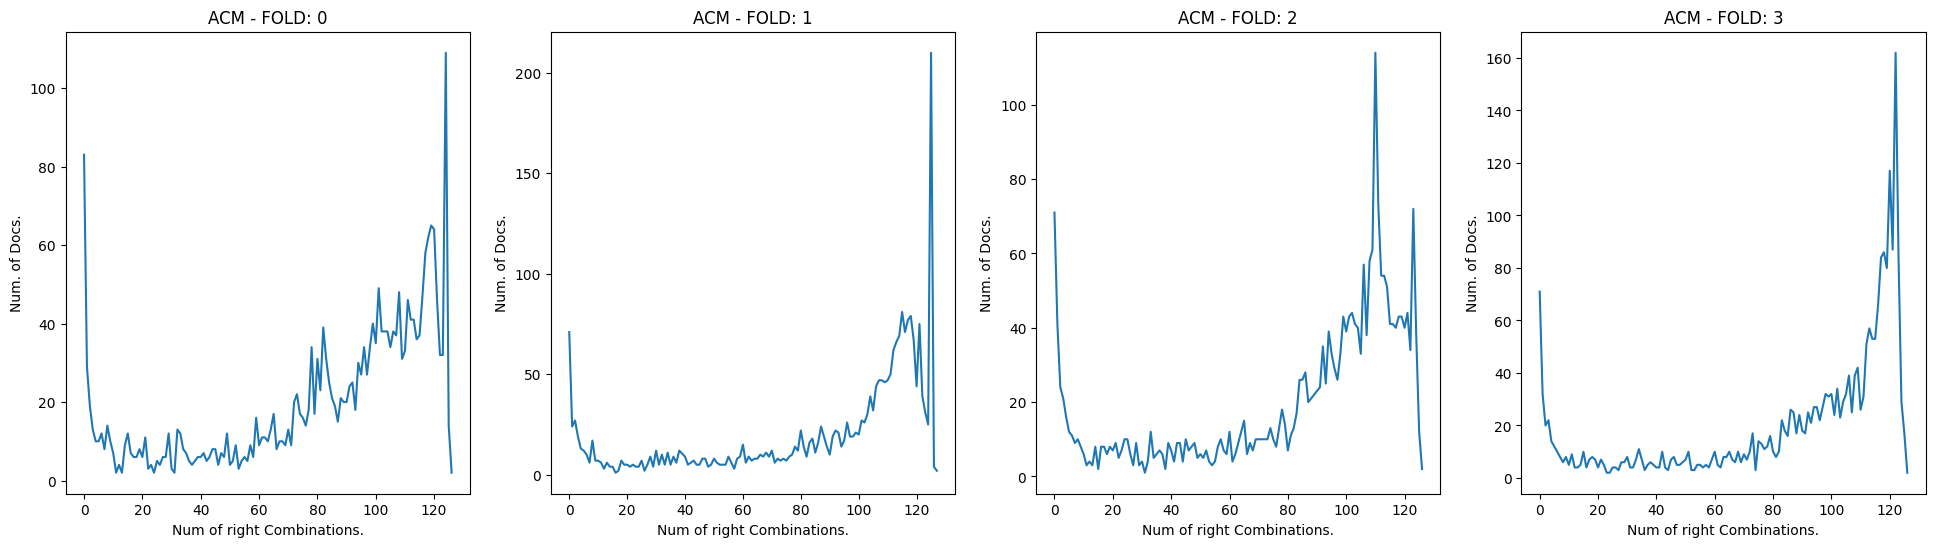

In [11]:
plt.figure(figsize=(24,6))
for fold in np.arange(4):

    plt.subplot(1, 4, fold +1) 
    plot(combs_hits[fold], f"{dataset.upper()} - FOLD: {fold}")
    

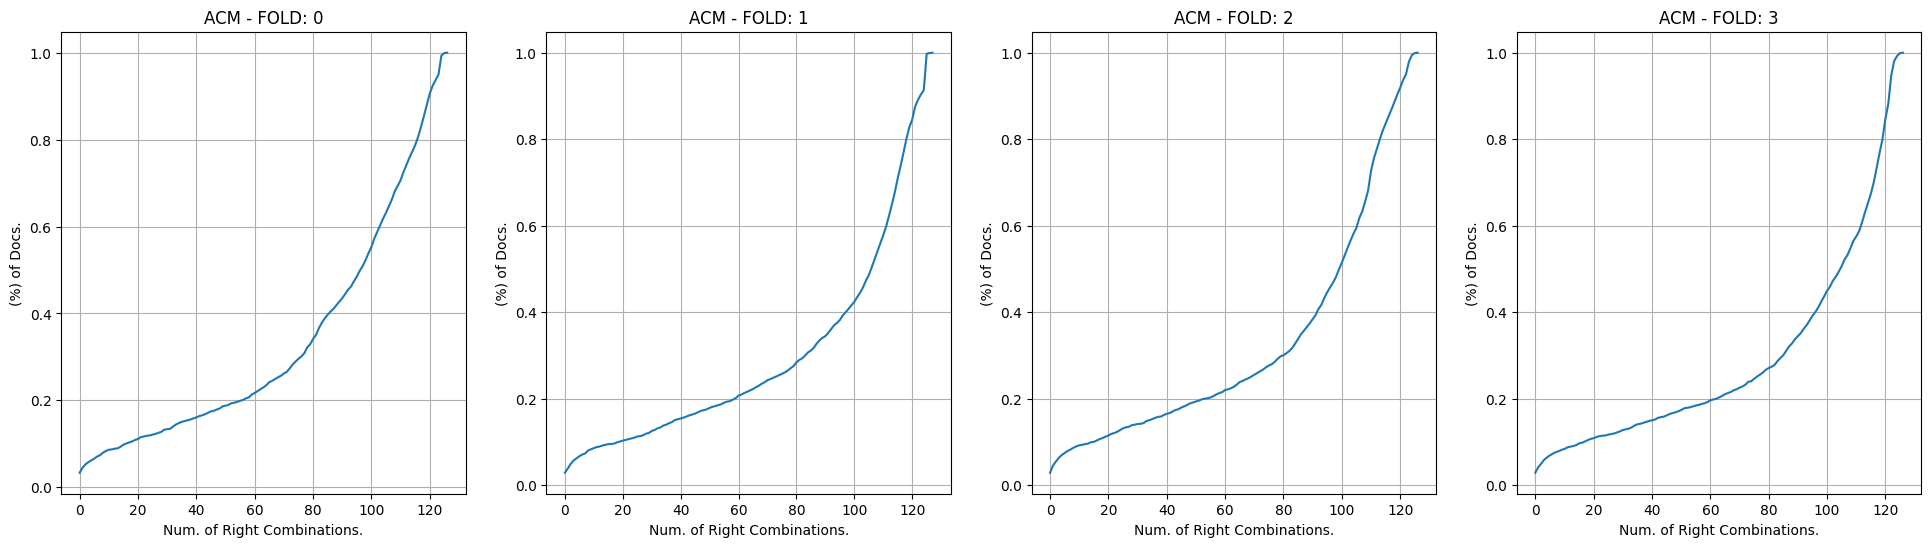

In [12]:
plt.figure(figsize=(24,6))
for fold in np.arange(4):

    plt.subplot(1, 4, fold +1) 
    plot_cdf(combs_hits[fold], f"{dataset.upper()} - FOLD: {fold}")